process video annotation export and do analysis

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("melda_swallow_annotations.csv")
df = df[df["VideoType"] == "swallow"]
df

,PatientID,ParsedFullVideoID,IsUsable,Comment,VideoType,PatientArtifact,accessory artifact,IsCRF,FullVideoID,ExtractedSwallowID,FrameCount,FPS,Duration,csv_FromFrame,csv_ToFrame,csv_Paradigm,csv_EventDescription,csv_Comment
1,46.0,Pt46_Visit1_fixed_000.mp4,1,NaN,swallow,NaN,NaN,False,Pt46,0.0,54.0,30.0,1.80,225.0,292.0,1 mL liquid bolus,Swallow,NaN
2,46.0,Pt46_Visit1_fixed_001.mp4,1,NaN,swallow,NaN,NaN,False,Pt46,1.0,58.0,30.0,1.93,516.0,583.0,1 mL liquid bolus,Swallow,NaN
3,46.0,Pt46_Visit1_fixed_002.mp4,0,barely visible,swallow,NaN,NaN,False,Pt46,2.0,41.0,30.0,1.37,929.0,990.0,1 mL liquid bolus,Swallow,NaN
4,46.0,Pt46_Visit1_fixed_003.mp4,1,NaN,swallow,NaN,NaN,False,Pt46,3.0,53.0,30.0,1.77,1055.0,1125.0,1 mL liquid bolus,Swallow,NaN
5,46.0,Pt46_Visit1_fixed_004.mp4,0.6,barely visible,swallow,NaN,NaN,False,Pt46,4.0,77.0,30.0,2.57,1591.0,1643.0,1 mL liquid bolus,Swallow,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,9931.0,Pt9931_Visit1_fixed_003.mp4,0,2,swallow,NaN,NaN,False,Pt9931,3.0,68.0,30.0,2.27,719.0,786.0,1 mL liquid bolus,Swallow,NaN
10944,9931.0,Pt9931_Visit1_fixed_004.mp4,1,NaN,swallow,NaN,NaN,False,Pt9931,4.0,75.0,30.0,2.50,1279.0,1353.0,1 mL liquid bolus,Swallow,NaN
10945,9931.0,Pt9931_Visit1_fixed_005.mp4,0,2,swallow,NaN,NaN,False,Pt9931,5.0,30.0,30.0,1.00,1957.0,1986.0,1 mL liquid bolus,Swallow,NaN
10946,9931.0,Pt9931_Visit1_fixed_006.mp4,1,NaN,swallow,NaN,NaN,False,Pt9931,6.0,38.0,30.0,1.27,2565.0,2602.0,1 mL liquid bolus,Swallow,NaN


### process is usable col

In [3]:
df["IsUsable"].value_counts()

IsUsable
1      5654
0      3871
0.8     240
wtf       5
0.4       2
0.6       1
          1
Name: count, dtype: int64

In [4]:
# value wtf set to 1
df["IsUsable"][df["IsUsable"] == "wtf"] = 1
df["IsUsable"][df["IsUsable"] == " "] = 0
# transform to float
df["IsUsable"] = df["IsUsable"].astype(float)
# all values between 0 and 1 are set to 0
df["IsUsable"][df["IsUsable"] < 1] = 0

C:\Users\ly37xoco\AppData\Local\Temp\ipykernel_15912\3385958263.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df["IsUsable"][df["IsUsable"] == "wtf"] = 1
C:\Users\ly37xoco\AppData\Local\Temp\ipykernel_15912\3385958263.py:3: FutureWarni

In [5]:
df["IsUsable"].value_counts()

IsUsable
1.0    5659
0.0    4115
Name: count, dtype: int64

In [6]:
# rename to is_usable
df.rename(columns={"IsUsable": "is_usable"}, inplace=True)

### create flag columns

In [7]:
'''
columns to be created:
- artifact_detected
- severe_movement
- visibility_issues
- accessory_artifact
- bolus_present_initially
- wrong_perspective
- bad_view
'''
# create cols
df["artifact_detected"] = 0
df["severe_movement"] = 0
df["visibility_issues"] = 0
df["accessory_artifact"] = 0
df["bolus_present_initially"] = 0


### process comment column

In [8]:
df["Comment"].value_counts()

Comment
2       2901
3       1151
51       808
4        469
51,3     332
        ... 
5,4        1
35         1
           1
1,4        1
20         1
Name: count, Length: 67, dtype: int64

In [9]:
'''
comments and their meaning:
1-barely visible	 -> visibility_issues
2-severe movement (21-forward) -> severe_movement
3-bolus present		  -> bolus_present_initially
4-patient artifact	  -> artifact_detected
5-accessory artifact (51-glasses, 50-earrings) 	-> accessory_artifact
7-badview		-> bad_view
8-wrongperspective		-> wrong_perspective
"software_artifact" -> software_artifact
"bolus present" -> bolus_present_initially
"image artifact" -> software_artifact
"barely visible" -> visibility_issues
"view" -> bad_view
"movement" -> severe_movement
"severe movement" -> severe_movement
"view?, artifact=" -> artifact_detected and bad_view
"barely visible, start missing" -> visibility_issues
"color?" -> software_artifact
"artefact_tocheck" -> software_artifact
"orientation" -> wrong_perspective
"bolus present, no swallow" -> bolus_present_initially
"perspective" -> wrong_perspective
"barely visible, camera movement" -> visibility_issues and severe_movement
"5,hand" -> accessory_artifact
"artifact" -> software_artifact


- value in cells can be list of values, f.e. possible values are 51,3 or 5 or 51,50,5 or ...
- comments are not just number or list of numbers, but also text or list of text or list of text and number
-
'''
# please now create the columns based on the values i have written above
# Convert all values to strings and split by comma
df["Comment"] = df["Comment"].astype(str).str.split(",")

# Create the columns based on the values
df["visibility_issues"] = df["Comment"].apply(lambda x: 1 if "1" in x else 0)
df["severe_movement"] = df["Comment"].apply(lambda x: 1 if "2" in x or "21" in x else 0)
df["bolus_present_initially"] = df["Comment"].apply(lambda x: 1 if "3" in x or "bolus present" in x or "bolus present, no swallow" in x else 0)
df["artifact_detected"] = df["Comment"].apply(lambda x: 1 if "4" in x or "view?, artifact=" in x else 0)
df["accessory_artifact"] = df["Comment"].apply(lambda x: 1 if "5" in x or "51" in x or "50" in x else 0)
df["bad_view"] = df["Comment"].apply(lambda x: 1 if "7" in x or "view" in x or "view?, artifact=" in x else 0)
df["wrong_perspective"] = df["Comment"].apply(lambda x: 1 if "8" in x or "orientation" in x or "perspective" in x else 0)
df["software_artifact"] = df["Comment"].apply(lambda x: 1 if "software_artifact" in x or "image artifact" in x or "color?" in x or "artefact_tocheck" in x or "artifact" in x else 0)


In [10]:
df

,PatientID,ParsedFullVideoID,is_usable,Comment,VideoType,PatientArtifact,accessory artifact,IsCRF,FullVideoID,ExtractedSwallowID,...,csv_EventDescription,csv_Comment,artifact_detected,severe_movement,visibility_issues,accessory_artifact,bolus_present_initially,bad_view,wrong_perspective,software_artifact
1,46.0,Pt46_Visit1_fixed_000.mp4,1.0,[nan],swallow,NaN,NaN,False,Pt46,0.0,...,Swallow,NaN,0,0,0,0,0,0,0,0
2,46.0,Pt46_Visit1_fixed_001.mp4,1.0,[nan],swallow,NaN,NaN,False,Pt46,1.0,...,Swallow,NaN,0,0,0,0,0,0,0,0
3,46.0,Pt46_Visit1_fixed_002.mp4,0.0,[barely visible],swallow,NaN,NaN,False,Pt46,2.0,...,Swallow,NaN,0,0,0,0,0,0,0,0
4,46.0,Pt46_Visit1_fixed_003.mp4,1.0,[nan],swallow,NaN,NaN,False,Pt46,3.0,...,Swallow,NaN,0,0,0,0,0,0,0,0
5,46.0,Pt46_Visit1_fixed_004.mp4,0.0,[barely visible],swallow,NaN,NaN,False,Pt46,4.0,...,Swallow,NaN,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10943,9931.0,Pt9931_Visit1_fixed_003.mp4,0.0,[2],swallow,NaN,NaN,False,Pt9931,3.0,...,Swallow,NaN,0,1,0,0,0,0,0,0
10944,9931.0,Pt9931_Visit1_fixed_004.mp4,1.0,[nan],swallow,NaN,NaN,False,Pt9931,4.0,...,Swallow,NaN,0,0,0,0,0,0,0,0
10945,9931.0,Pt9931_Visit1_fixed_005.mp4,0.0,[2],swallow,NaN,NaN,False,Pt9931,5.0,...,Swallow,NaN,0,1,0,0,0,0,0,0
10946,9931.0,Pt9931_Visit1_fixed_006.mp4,1.0,[nan],swallow,NaN,NaN,False,Pt9931,6.0,...,Swallow,NaN,0,0,0,0,0,0,0,0


In [11]:
# show rows where Comment is  empty ([nan] is empty) and where the sum of all flags is 0
df[(df["Comment"] == "[nan]") & (df[["visibility_issues", "severe_movement", "bolus_present_initially", "artifact_detected", "accessory_artifact", "bad_view", "wrong_perspective", "software_artifact"]].sum(axis=1) == 0)]

,PatientID,ParsedFullVideoID,is_usable,Comment,VideoType,PatientArtifact,accessory artifact,IsCRF,FullVideoID,ExtractedSwallowID,...,csv_EventDescription,csv_Comment,artifact_detected,severe_movement,visibility_issues,accessory_artifact,bolus_present_initially,bad_view,wrong_perspective,software_artifact


In [12]:
df["artifact_detected"].value_counts()

artifact_detected
0    8776
1    1048
Name: count, dtype: int64

In [13]:
df["accessory_artifact"].value_counts()

accessory_artifact
0    7899
1    1925
Name: count, dtype: int64

### process additionally PatientArtifact col and accessory artifact col

In [14]:
'''
PatientArtifact:
1 -> artifact_detected

AccessoryArtifact:
glasses -> accessory_artifact
'''
# if PatientArtifact is 1, set artifact_detected to 1, if glasses in AccessoryArtifact, set accessory_artifact to 1
df["PatientArtifact"] = df["PatientArtifact"].astype(str)
df["accessory artifact"] = df["accessory artifact"].astype(str)

df["artifact_detected"] = df["artifact_detected"] | df["PatientArtifact"].apply(lambda x: 1 if "1" in x else 0)
df["accessory_artifact"] = df["accessory_artifact"] | df["accessory artifact"].apply(lambda x: 1 if "glasses" in x else 0)

In [15]:
df["artifact_detected"].value_counts()

artifact_detected
0    8745
1    1079
Name: count, dtype: int64

In [16]:
df["accessory_artifact"].value_counts()

accessory_artifact
0    7894
1    1930
Name: count, dtype: int64

# Flag Statistics

In [17]:
df.columns

Index(['PatientID', 'ParsedFullVideoID', 'is_usable', 'Comment', 'VideoType',
       'PatientArtifact', 'accessory artifact', 'IsCRF', 'FullVideoID',
       'ExtractedSwallowID', 'FrameCount', 'FPS', 'Duration', 'csv_FromFrame',
       'csv_ToFrame', 'csv_Paradigm', 'csv_EventDescription', 'csv_Comment',
       'artifact_detected', 'severe_movement', 'visibility_issues',
       'accessory_artifact', 'bolus_present_initially', 'bad_view',
       'wrong_perspective', 'software_artifact'],
      dtype='object')

In [18]:
df["visibility_issues"].value_counts()

visibility_issues
0    9555
1     269
Name: count, dtype: int64

In [19]:
df["severe_movement"].value_counts()

severe_movement
0    6877
1    2947
Name: count, dtype: int64

In [20]:
df["bolus_present_initially"].value_counts()

bolus_present_initially
0    7603
1    2221
Name: count, dtype: int64

In [21]:
df["artifact_detected"].value_counts()

artifact_detected
0    8745
1    1079
Name: count, dtype: int64

In [22]:
df["accessory_artifact"].value_counts()

accessory_artifact
0    7894
1    1930
Name: count, dtype: int64

In [23]:
df["bad_view"].value_counts()

bad_view
0    9661
1     163
Name: count, dtype: int64

In [24]:
df["wrong_perspective"].value_counts()

wrong_perspective
0    9510
1     314
Name: count, dtype: int64

In [25]:
df["software_artifact"].value_counts()

software_artifact
0    9659
1     165
Name: count, dtype: int64

In [26]:
df["is_usable"].value_counts()

is_usable
1.0    5659
0.0    4115
Name: count, dtype: int64

In [28]:
# count of videos where is usable is 1 and the sum of all flags is 0
df[(df["is_usable"] == 1) & (df[["visibility_issues", "severe_movement", "bad_view", "wrong_perspective", "software_artifact"]].sum(axis=1) == 0)].shape

(5623, 26)

In [29]:
# count of videos where is usable is 1 and the sum of all flags is 0
df[(df["is_usable"] == 1) & (df[["visibility_issues", "severe_movement", "bolus_present_initially", "artifact_detected", "accessory_artifact", "bad_view", "wrong_perspective", "software_artifact"]].sum(axis=1) == 0)].shape

(1884, 26)

In [30]:
# also show in percent
df["visibility_issues"].value_counts(normalize=True)

visibility_issues
0    0.972618
1    0.027382
Name: proportion, dtype: float64

# Bar Plot of Flags

In [31]:
'''
i want to create graphs that show how often we have a flag type (all 9) for all videos
'''
# create a new df with the sum of all flags
#create column is not usable as inverse of is_usable
df["is_not_usable"] = 1 - df["is_usable"]
df["is_not_usable"] = df["is_not_usable"].astype(bool)
# create column "other" for videos that are not usable and have no flags
df["other"] = df["is_not_usable"] & (df[["visibility_issues", "severe_movement", "bolus_present_initially", "artifact_detected", "accessory_artifact", "bad_view", "wrong_perspective", "software_artifact"]].sum(axis=1) == 0)
df_flags = df[["is_not_usable", "visibility_issues", "severe_movement", "bolus_present_initially", "artifact_detected", "accessory_artifact", "bad_view", "wrong_perspective", "software_artifact", "other"]].sum()
df_flags

is_not_usable              4165
visibility_issues           269
severe_movement            2947
bolus_present_initially    2221
artifact_detected          1079
accessory_artifact         1930
bad_view                    163
wrong_perspective           314
software_artifact           165
other                       192
dtype: int64

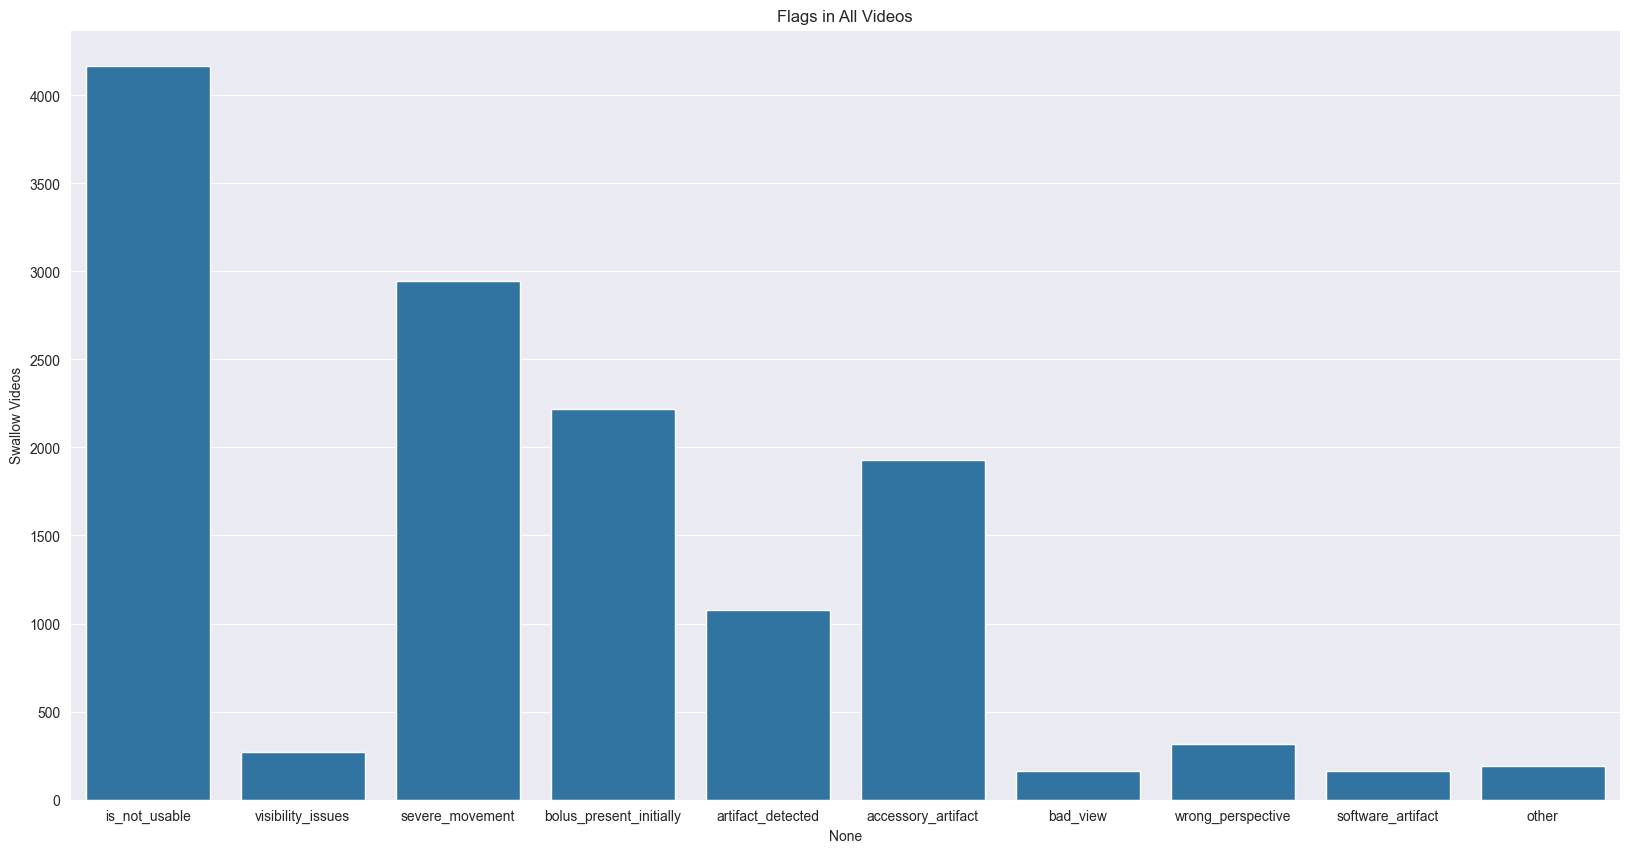

In [32]:
# create a bar plot
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,10))
sns.barplot(x=df_flags.index, y=df_flags.values)
# add y label: swallow videos
plt.ylabel("Swallow Videos")
# add title: Flags in Usable Videos
plt.title("Flags in All Videos")
plt.show()


# Bar Plot of flags with usable videos

C:\Users\ly37xoco\AppData\Local\Temp\ipykernel_15912\2403801202.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flags_usable["perfect"] = (df_flags_usable[["visibility_issues", "severe_movement", "bolus_present_initially", "artifact_detected", "accessory_artifact", "bad_view", "wrong_perspective", "software_artifact"]].sum(axis=1) == 0)


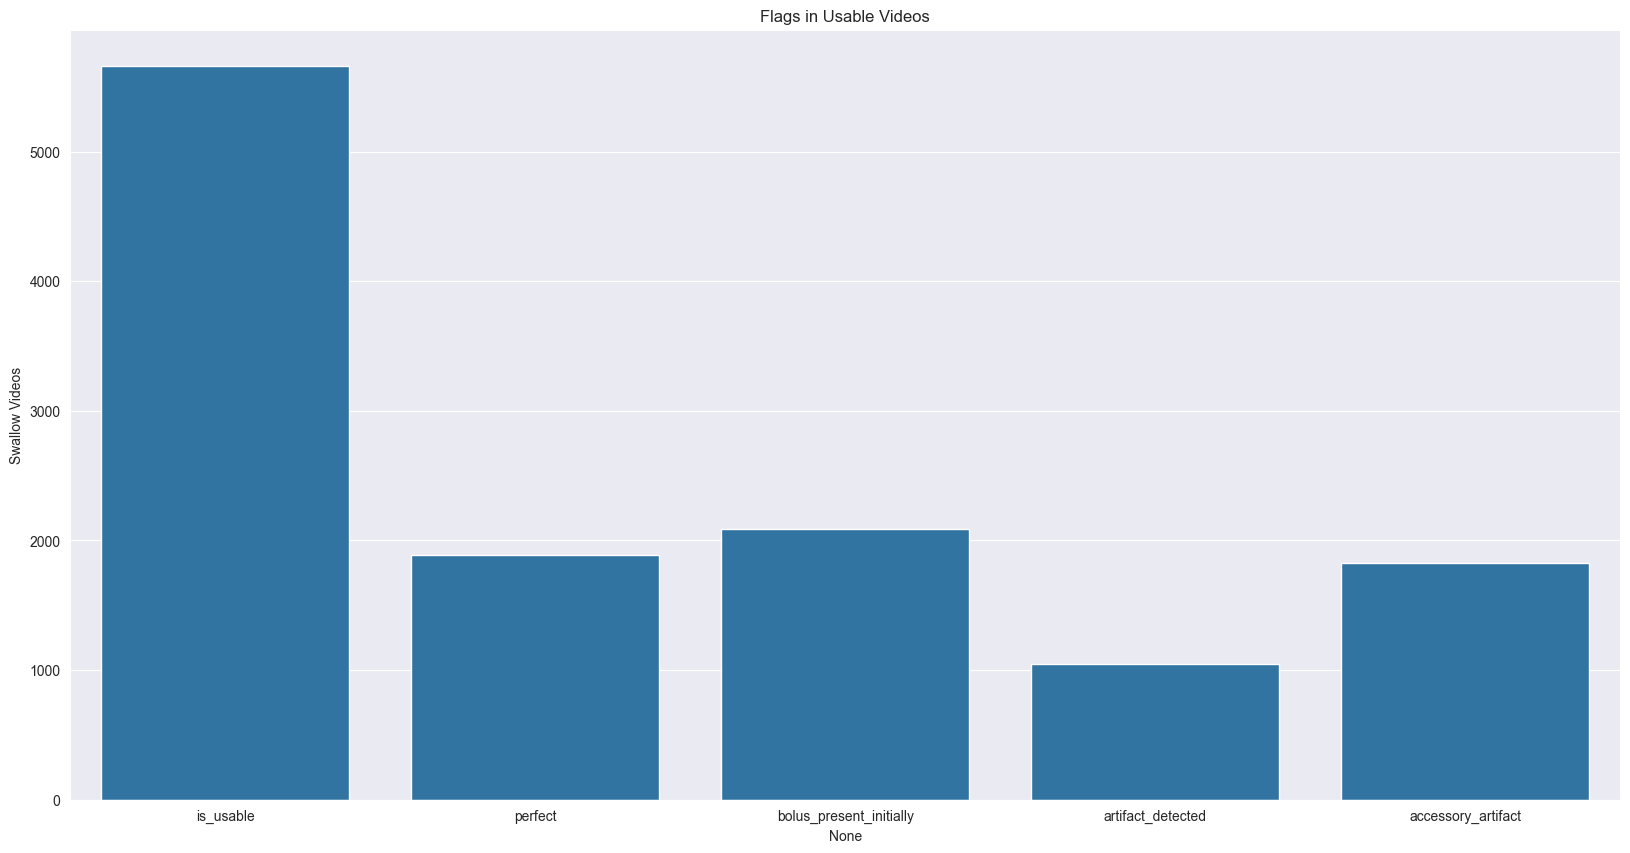

In [33]:

df_flags_usable = df[df["is_usable"] == 1]
# create column "no flags" for videos that are usable and have no flags
df_flags_usable["perfect"] = (df_flags_usable[["visibility_issues", "severe_movement", "bolus_present_initially", "artifact_detected", "accessory_artifact", "bad_view", "wrong_perspective", "software_artifact"]].sum(axis=1) == 0)
df_flags_usable = df_flags_usable[["is_usable", "perfect", "bolus_present_initially", "artifact_detected", "accessory_artifact"]].sum()
plt.figure(figsize=(20,10))
sns.barplot(x=df_flags_usable.index, y=df_flags_usable.values)
# add y label: swallow videos
plt.ylabel("Swallow Videos")
# add title: Flags in Usable Videos
plt.title("Flags in Usable Videos")
plt.show()

In [34]:
df_flags_usable

is_usable                  5659.0
perfect                    1884.0
bolus_present_initially    2088.0
artifact_detected          1043.0
accessory_artifact         1825.0
dtype: float64

In [35]:
df.columns

Index(['PatientID', 'ParsedFullVideoID', 'is_usable', 'Comment', 'VideoType',
       'PatientArtifact', 'accessory artifact', 'IsCRF', 'FullVideoID',
       'ExtractedSwallowID', 'FrameCount', 'FPS', 'Duration', 'csv_FromFrame',
       'csv_ToFrame', 'csv_Paradigm', 'csv_EventDescription', 'csv_Comment',
       'artifact_detected', 'severe_movement', 'visibility_issues',
       'accessory_artifact', 'bolus_present_initially', 'bad_view',
       'wrong_perspective', 'software_artifact', 'is_not_usable', 'other'],
      dtype='object')

In [112]:
# save the processed data
columns_needed = ["PatientID", "ParsedFullVideoID", "VideoType", "is_usable", "artifact_detected", "severe_movement", "visibility_issues", "accessory_artifact", "bolus_present_initially", "wrong_perspective", "bad_view", "software_artifact", "ExtractedSwallowID", "FrameCount", "FPS", "Duration", ]
df_export = df[columns_needed]
df_export.to_csv("melda_swallow_annotations_final.csv", index=False)

In [48]:
df.shape[0]

9824

### patient analysis

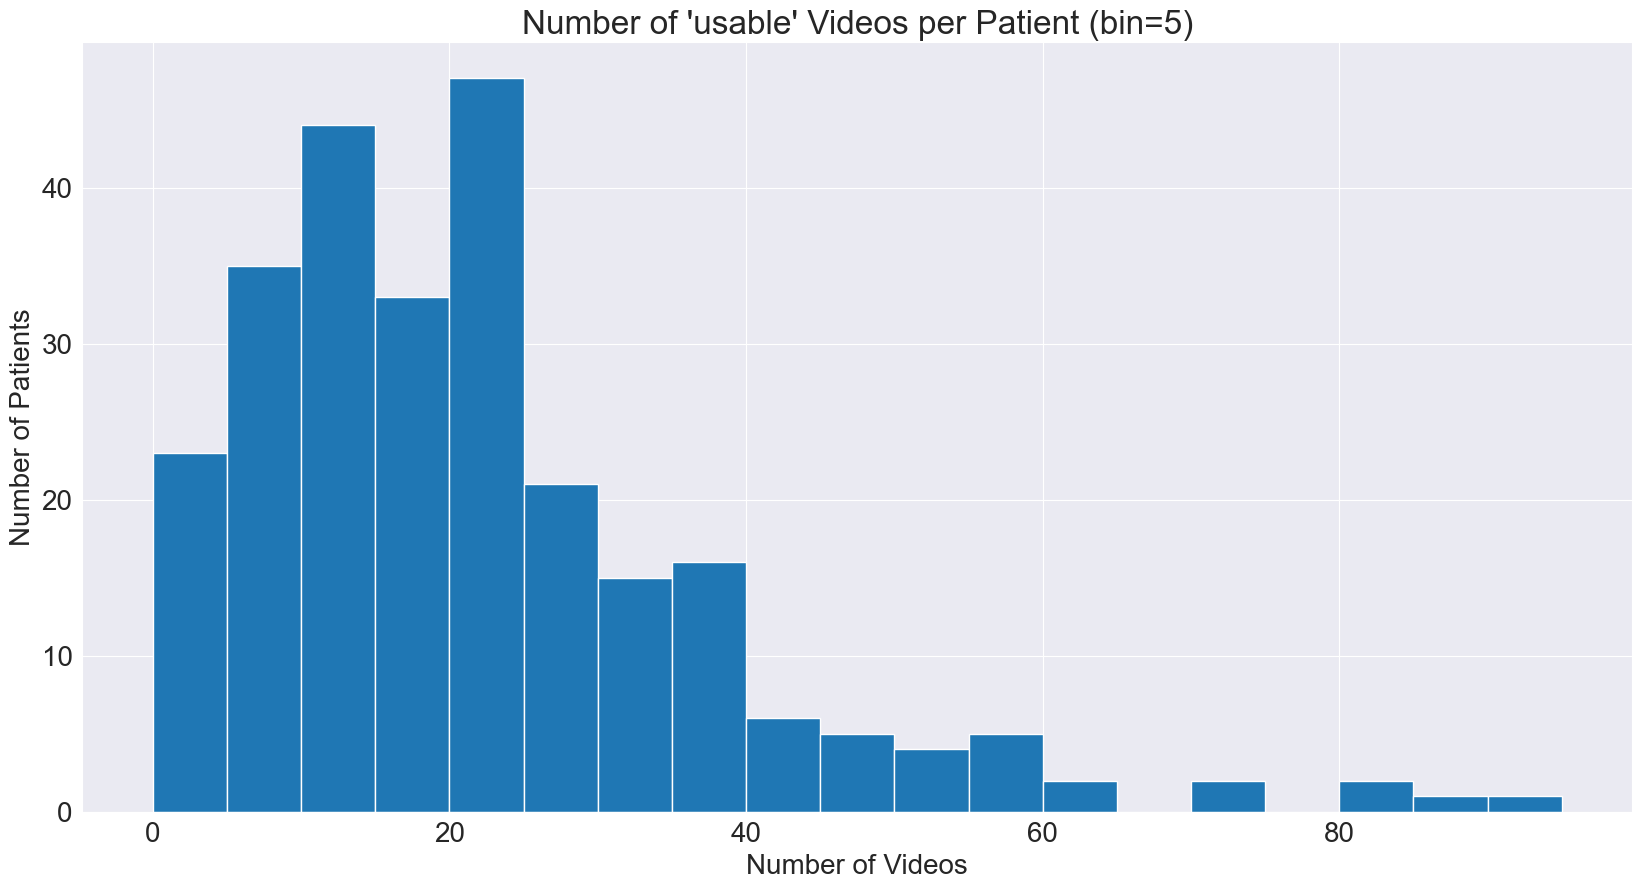

In [52]:
# for videos that are usable, plot x: number of videos per patient, y: number of patients with that number of videos
df_usable = df[(df["is_usable"] == 1) & (df[["visibility_issues", "severe_movement", "bad_view", "wrong_perspective", "software_artifact"]].sum(axis=1) == 0)]
df_patients = df_usable.groupby("PatientID").size().reset_index(name='counts')
#histogram with bins that are video conuts in 5 steps
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20,10))
plt.hist(df_patients["counts"], bins=range(0, 100, 5))
plt.xlabel("Number of Videos")
plt.ylabel("Number of Patients")
plt.title("Number of 'usable' Videos per Patient (bin=5)")
plt.show()


In [37]:
# how many unique patients do we have
df["PatientID"].nunique()

277

In [55]:
df_patients.shape[0]

262

In [56]:
df_patients["counts"].describe()

count    262.000000
mean      21.461832
std       16.066089
min        1.000000
25%       10.250000
50%       19.000000
75%       28.000000
max       93.000000
Name: counts, dtype: float64

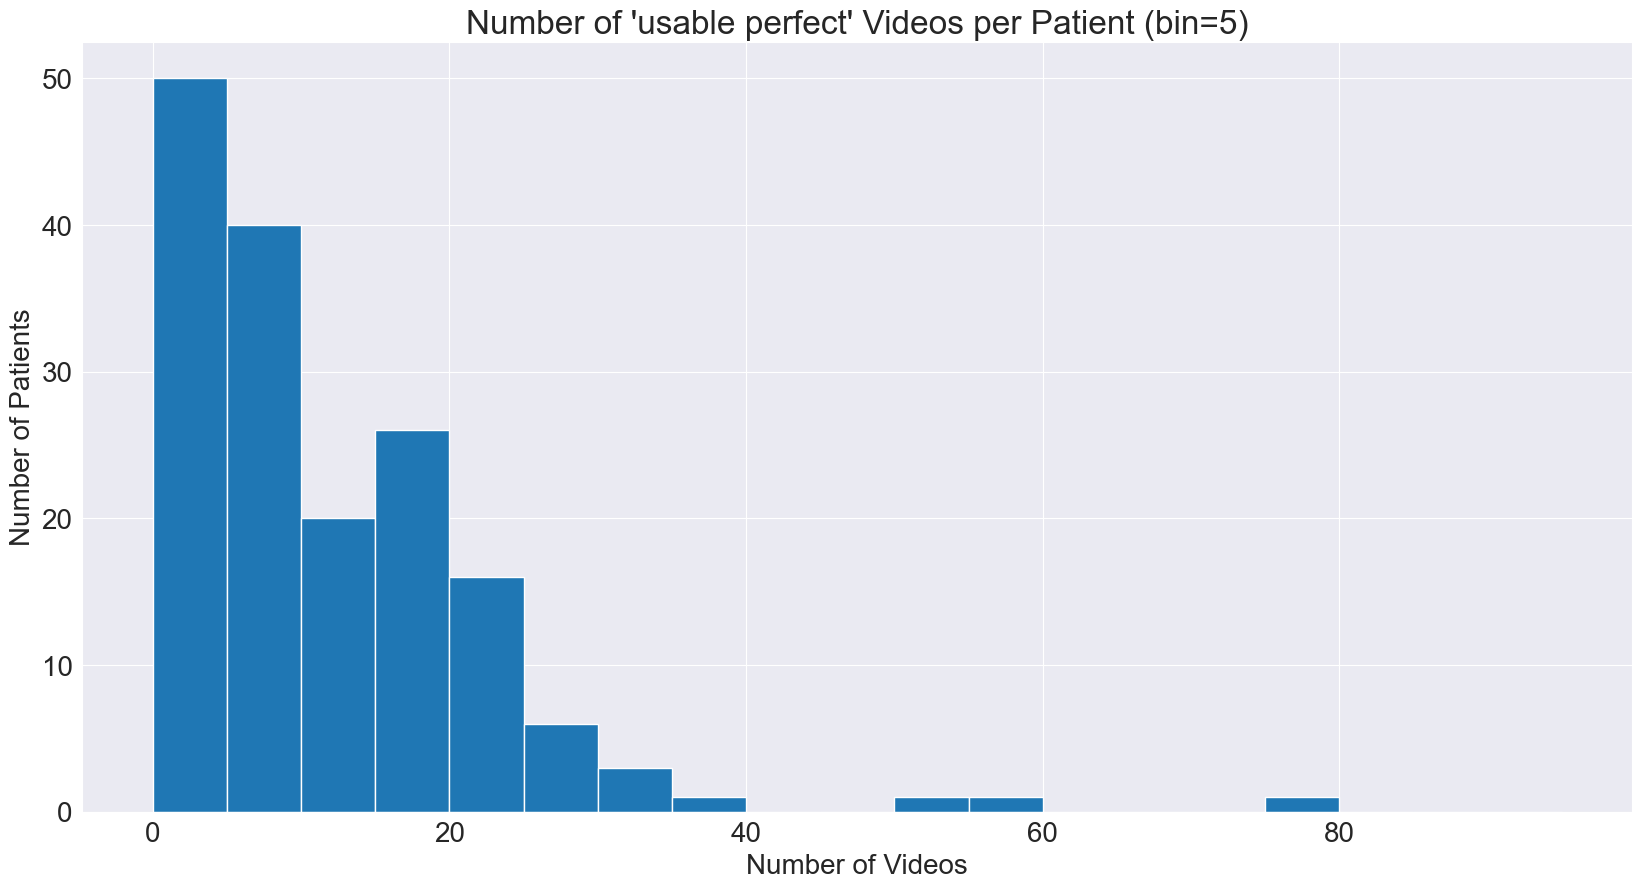

In [53]:
# for videos that are usable, plot x: number of videos per patient, y: number of patients with that number of videos
df_usable_perfect = df[(df["is_usable"] == 1) & (df[["visibility_issues", "severe_movement", "bad_view", "wrong_perspective", "software_artifact", "bolus_present_initially", "accessory_artifact", "artifact_detected"]].sum(axis=1) == 0)]
df_patients_perfect = df_usable_perfect.groupby("PatientID").size().reset_index(name='counts')
#histogram with bins that are video conuts in 5 steps
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.hist(df_patients_perfect["counts"], bins=range(0, 100, 5))
plt.xlabel("Number of Videos")
plt.ylabel("Number of Patients")
plt.title("Number of 'usable perfect' Videos per Patient (bin=5)")
plt.show()


In [40]:
# how many unique patients do we have
df_usable_perfect["PatientID"].nunique()

165

In [41]:
df_usable_perfect.shape[0]

1884

In [42]:
df_patients_perfect["counts"].describe()

count    165.000000
mean      11.418182
std       10.990058
min        1.000000
25%        3.000000
50%        9.000000
75%       17.000000
max       77.000000
Name: counts, dtype: float64